In [1]:
!nvidia-smi

Mon Jul 18 05:00:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   40C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
tf.__version__

'2.9.1'

In [4]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

In [5]:
!pwd

/home/studio-lab-user/sagemaker-studiolab-notebooks/tomato


In [15]:
train_path = 'data/train'
valid_path = 'data/valid'
IMAGE_SIZE = [224,224]

In [9]:
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 2s 0us/step


In [10]:
for layer in inception.layers:
    layer.trainable = False

In [14]:
folders = glob('data/train/*')
folders

['data/train/Tomato___Bacterial_spot',
 'data/train/Tomato___Early_blight',
 'data/train/Tomato___Late_blight',
 'data/train/Tomato___Leaf_Mold',
 'data/train/Tomato___Septoria_leaf_spot',
 'data/train/Tomato___Spider_mites Two-spotted_spider_mite',
 'data/train/Tomato___Target_Spot',
 'data/train/Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'data/train/Tomato___Tomato_mosaic_virus',
 'data/train/Tomato___healthy']

In [16]:
x = Flatten()(inception.output)
prediction = Dense(len(folders),activation='softmax')(x)
model = Model(inputs = inception.input, outputs=prediction)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [18]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./225,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale = 1./225)

In [20]:
traning_set = train_datagen.flow_from_directory(train_path,
                                                target_size=(224,224),
                                                batch_size=32,
                                                class_mode='categorical')

Found 18347 images belonging to 10 classes.


In [22]:
test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size=(224,224),
                                            batch_size=32,
                                            class_mode='categorical')

Found 4585 images belonging to 10 classes.


In [ ]:
r = model.fit_generator(traning_set,
                        validation_data = test_set,
                        epochs=10,
                        steps_per_epoch = len(traning_set),
                        validation_steps=len(test_set))

/tmp/ipykernel_1815/2650872786.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(traning_set,


Epoch 1/10
574/574 [==============================] - 193s 325ms/step - loss: 2.9714 - accuracy: 0.6808 - val_loss: 3.5374 - val_accuracy: 0.6968
Epoch 2/10
574/574 [==============================] - 185s 323ms/step - loss: 2.2111 - accuracy: 0.7848 - val_loss: 1.7562 - val_accuracy: 0.8185
Epoch 3/10
574/574 [==============================] - 186s 323ms/step - loss: 1.9574 - accuracy: 0.8260 - val_loss: 2.9559 - val_accuracy: 0.7815
Epoch 4/10
574/574 [==============================] - 184s 320ms/step - loss: 1.8598 - accuracy: 0.8445 - val_loss: 1.4773 - val_accuracy: 0.8691
Epoch 5/10
574/574 [==============================] - 184s 321ms/step - loss: 1.9384 - accuracy: 0.8501 - val_loss: 3.0844 - val_accuracy: 0.8124
Epoch 6/10
574/574 [==============================] - 183s 319ms/step - loss: 1.8864 - accuracy: 0.8664 - val_loss: 2.8431 - val_accuracy: 0.8342
Epoch 8/10
574/574 [==============================] - 185s 322ms/step - loss: 1.6672 - accuracy: 0.8810 - val_loss: 3.1790 -

In [ ]:
import matplotlib.pyplot as plt

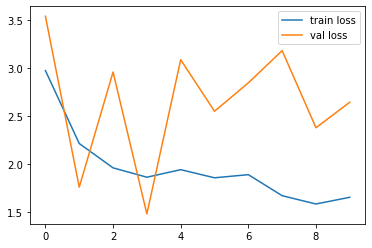

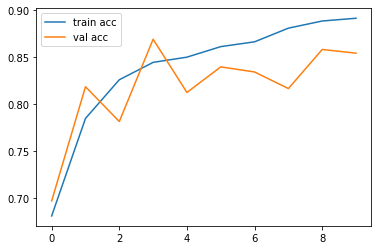

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
from tensorflow.keras.models import load_model

model.save('model_inception.h5')

In [ ]:
y_pred = model.predict(test_set)

144/144 [==============================] - 11s 66ms/step


In [ ]:
y_pred

array([[1.49402756e-12, 5.53942348e-24, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.24028577e-28],
       [1.01683275e-27, 5.82788790e-16, 9.95601654e-01, ...,
        0.00000000e+00, 0.00000000e+00, 9.06486877e-34],
       [0.00000000e+00, 1.00000000e+00, 1.05683333e-26, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.51062530e-04, 6.12814705e-17, 5.24468296e-24, ...,
        5.37570818e-20, 1.22460442e-08, 3.82389590e-06],
       [1.00000000e+00, 8.22574217e-24, 0.00000000e+00, ...,
        1.00556888e-24, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 4.91394019e-36, 0.00000000e+00]], dtype=float32)